Found text-based columns: ['Hand_cross', 'MRI_ID', 'Group', 'Hand_long', 'M/F']
Dropped unexpected text column: Hand_cross
Dropped unexpected text column: MRI_ID
Dropped unexpected text column: Group
Dropped unexpected text column: Hand_long
Encoded column: M/F

Missing values check after imputation:
Educ        0
Delay       0
Visit       0
MR Delay    0
EDUC        0
CDR         0
MMSE        0
nWBV        0
ASF         0
eTIV        0
SES         0
M/F         0
Age         0
dtype: int64

Final data types before saving:
<class 'pandas.core.frame.DataFrame'>
Index: 809 entries, OAS1_0001_MR1 to OAS2_0186
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Educ      809 non-null    float64
 1   Delay     809 non-null    float64
 2   Visit     809 non-null    float64
 3   MR Delay  809 non-null    float64
 4   EDUC      809 non-null    float64
 5   CDR       809 non-null    float64
 6   MMSE      809 non-null    float64
 

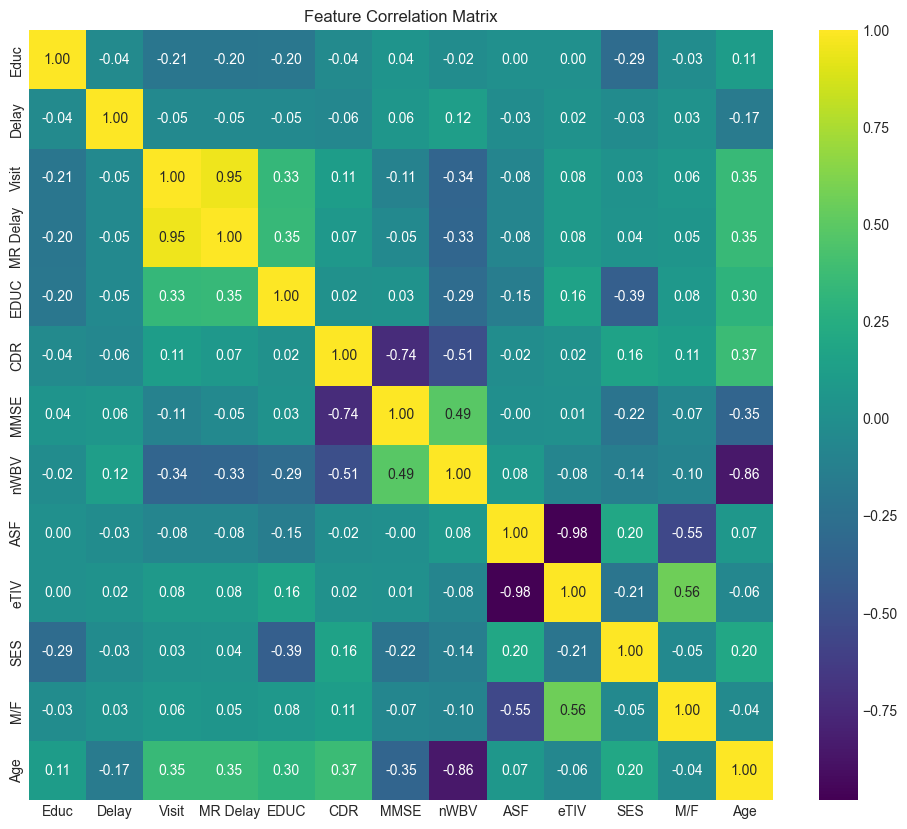

In [3]:
# 1_dataset_analysis.ipynb (Corrected for ValueError)

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Load the datasets
try:
    df_cross = pd.read_csv('data\oasis_cross-sectional.csv')
    df_long = pd.read_csv('data\oasis_longitudinal.csv')
except FileNotFoundError:
    print("Make sure 'oasis_cross-sectional.csv' and 'oasis_longitudinal.csv' are in the same directory.")
    df_cross = pd.DataFrame()
    df_long = pd.DataFrame()

# --- Data Combination and Initial Cleaning ---
df_cross.rename(columns={'ID': 'Subject ID'}, inplace=True)
df_long.rename(columns={'MRI ID': 'MRI_ID'}, inplace=True)
df_combined = pd.merge(df_cross, df_long, on='Subject ID', how='outer', suffixes=('_cross', '_long'))

for col in ['CDR', 'MMSE', 'nWBV', 'ASF', 'eTIV', 'SES']:
    if f'{col}_cross' in df_combined.columns and f'{col}_long' in df_combined.columns:
        df_combined[col] = df_combined[f'{col}_long'].fillna(df_combined[f'{col}_cross'])
        df_combined.drop([f'{col}_cross', f'{col}_long'], axis=1, inplace=True)

df_combined['M/F'] = df_combined['M/F_long'].fillna(df_combined['M/F_cross'])
df_combined['Age'] = df_combined['Age_long'].fillna(df_combined['Age_cross'])
cols_to_drop_initial = ['M/F_cross', 'M/F_long', 'Age_cross', 'Age_long', 'Group_cross', 'Group_long',
                        'MRI_ID_cross', 'MRI_ID_long', 'Visit_cross', 'Visit_long',
                        'MR Delay_cross', 'MR Delay_long']
df_combined.drop(columns=[col for col in cols_to_drop_initial if col in df_combined.columns], inplace=True)

df_combined.set_index('Subject ID', inplace=True)

# --- NEW: Robustly Handle All Text Columns ---
# This is the key fix for the ValueError. We will find all non-numeric columns.
object_cols = df_combined.select_dtypes(include='object').columns.tolist()
print(f"Found text-based columns: {object_cols}")

le = LabelEncoder()
for col in object_cols:
    if col == 'M/F':
        # We want to keep 'M/F' and encode it numerically
        df_combined[col] = le.fit_transform(df_combined[col])
        print(f"Encoded column: {col}")
    else:
        # Any other text column is not needed for this model, so we drop it
        df_combined.drop(col, axis=1, inplace=True)
        print(f"Dropped unexpected text column: {col}")


# --- Handle Missing Values ---
# Fill remaining NaNs using the mode for each column.
for column in df_combined.columns:
    if df_combined[column].isnull().any():
        mode_value = df_combined[column].mode()[0]
        df_combined[column].fillna(mode_value, inplace=True)

print("\nMissing values check after imputation:")
print(df_combined.isnull().sum())

print("\nFinal data types before saving:")
df_combined.info()

# --- Feature Correlation Analysis ---
plt.figure(figsize=(12, 10))
sns.heatmap(df_combined.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.savefig('results/correlation_matrix.png')
#plt.show() # Commenting out to prevent display in automated environments if needed


# --- Save the Processed Data ---
df_combined.to_csv('processed_data.csv')
print("\nProcessed data saved to 'processed_data.csv'")
print("\nAnalysis and preprocessing complete. You can now run Notebook 2.")